# Análise Geral dos dados

Este arquivo apresenta uma visão geral dos dados do RGPS no período de 1995 a 2016.

## Estrutura do banco de dados

Inicialmente é apresentada uma visão geral da estrutura do banco de dados.

In [1]:
import sqlite3
import pandas as pd
                        
# Função que executa as queries no banco de dados
def run_query(q):
    with sqlite3.connect('microdados/sqlite3/microdadosRGPS.db') as conn:
        return pd.read_sql(q, conn)

Lendo as tabelas do banco dados:

In [2]:
query = "SELECT name,type FROM sqlite_master WHERE type IN ('table')"
run_query(query)

,name,type
0,apos_aux,table
1,pensoes,table


O banco possui duas tabelas, uma com os dados das aposentadorias e auxílios (***apos_aux***) e outra com as pensões.

Em seguida, verificamos o esquema e quantidade de registros em cada uma das tabelas:

In [3]:
for tabela in ["apos_aux", "pensoes"]:
    registros = run_query('SELECT COUNT(ESPECIE) as count FROM {}'.format(tabela)).loc[0,'count']
    print("\nTabela: {} - {} registros".format(tabela,registros))
    print("Esquema da tabela:")
    print(run_query("pragma table_info(apos_aux);"))
    print("-"*40)    


Tabela: apos_aux - 57955872 registros
Esquema da tabela:
    cid           name     type  notnull dflt_value  pk
0     0        ESPECIE  INTEGER        0       None   0
1     1            DIB     TEXT        0       None   0
2     2            DDB     TEXT        0       None   0
3     3   MOT_CESSACAO  INTEGER        0       None   0
4     4  ULT_COMPET_MR  INTEGER        0       None   0
5     5          VL_MR     TEXT        0       None   0
6     6        DT_NASC     TEXT        0       None   0
7     7         VL_RMI     TEXT        0       None   0
8     8      CLIENTELA  INTEGER        0       None   0
9     9           SEXO  INTEGER        0       None   0
10   10       SITUACAO  INTEGER        0       None   0
11   11       DT_OBITO     TEXT        0       None   0
12   12      IDADE_DIB  INTEGER        0       None   0
13   13  TEMPO_CONTRIB  INTEGER        0       None   0
----------------------------------------

Tabela: pensoes - 7964185 registros
Esquema da tabela:
    c

Como observado a tabela ***apos_aux*** possui mais de 57 milhões de registros e a tabela ***pensoes*** possui quase 8 milhões de registros.
Além das quantidades de registros, a saída também apresenta os esquemas de cada umas das tabelas, sendo que ambas possuem 14 colunas.

A tabela abaixo apresenta uma breve descrição do significado das quatro primeiras colunas da tabela ***apos_aux***. 

|CAMPO|DESCRIÇÃO|
|---|---|
|ESPECIE|Espécie de Benefício|
|DIB|Data de Início do Benefício|
|DDB|Data de Despacho do Benefício|
|MOT_CESSACAO|Motivo de Cessação|

O arquivo ***metadados.xls***, disponibilizado junto com o banco de dados, apresenta uma descrição detalhada de ambas as tabelas.

A maioria dos dados é apresentada com códigos, assim, para o entendimento dos dados é necessário utilizar o arquivo ***dicionario.txt***, disponibilizado junto com banco, para que se possa entender os dados de cada coluna.
Abaixo segue uma parte do arquivo de dicionário:

* ESPÉCIE DE BENEFÍCIO (ESPECIE)

|CÓDIGO|VALOR|
|---|---|
|'01'|'B01 Pensão por morte do trab. rural'|    
|'02'|'B02 Pensão por morte acid. do trab. rural'|
|...||
|'95'|'B95 Auxílio-suplementar por acidente do trabalho'|
|'96'|'B96 Pensão especias às pessoas atingidas pela hanseníase'|


* VÍNCULO DE DEPENDENTE (VINC_DEP)

|CÓDIGO|VALOR|
|---|---|
|1|"Cônjuge"|
|2|"Filho(a)"| 
|...||
|9|"Dependente judicial"|
|99|"Ignorado"|
    

## Visão geral dos dados de Aposentadorias e Auxílios

Como primeira parte da análise, segue uma visão dos dados contidos na tabela ***apos_aux***.

Uma das principais colunas da tabela é a coluna *ESPECIE*, que contém o tipo de benefício. Então, vamos verificar quantos registros existem para cada tipo de benefício da tabela.

In [4]:
# O arquivo "dicionario_dados.py" possui os mesmos dados do "dicionario.txt", porém convertidos para dicionários Python
# Carrega as variáveis do arquivo de dicionário
%run util/dicionario_dados.py

# Executa a query e salva o DataFrame 
registros_por_benef = run_query("SELECT ESPECIE as Codigo, COUNT(ESPECIE) as qtd_registros FROM apos_aux \
          GROUP BY ESPECIE ORDER BY qtd_registros")

# Cria uma nova coluna com o nome do benefício
registros_por_benef['Beneficio'] = registros_por_benef['Codigo'].apply(lambda x: codigos_especie[x])
# Reordena as colunas
registros_por_benef = registros_por_benef[['Beneficio', 'Codigo', 'qtd_registros']]
registros_por_benef

,Beneficio,Codigo,qtd_registros
0,Aposentadoria por tempo de serviço de professor,57,114406
1,Aposentadoria por tempo de serviço especial,46,188462
2,Aposentadoria por invalidez por acidente do tr...,92,189969
3,Aposentadoria por invalidez previdenciária,32,3725842
4,Auxílio-doença por acidente do trabalho,91,4877036
5,Aposentadoria por tempo de serviço previdenciária,42,5272829
6,Aposentadoria por idade,41,10568276
7,Auxílio-doença previdenciário,31,33019052


Conforme a tabela acima, o benefício com código 31, que corresponde ao benefício *Auxílio-doença previdenciário* é o que possui mais registros, seguido da *Aposentadoria por idade*.

Foi observado que nem todos os benefícios estão contidos nos dados. 
O arquivo de dicionário descreve **78 tipos** de benefícios, sendo que 24 destes são do tipo *Pensão*, restando 54 tipos de benefícios descritos abaixo:

In [5]:
sorted([x for x in list(codigos_especie.values()) if 'Pens' not in x])

['Abono de permanência em serviço 20%',
 'Abono de permanência em serviço 25%',
 'Abono de servidor aposentado pela autarquia empreg.',
 'Amparo Assistencial ao idoso',
 'Amparo assistencial ao portador de deficiência',
 'Aposentadoria da extinta CAPIN',
 'Aposentadoria de extranumerário da União',
 'Aposentadoria excepcional do anistiado',
 'Aposentadoria por idade',
 'Aposentadoria por idade (Extinto Plano Básico)',
 'Aposentadoria por idade compulsória (Ex-SASSE)',
 'Aposentadoria por idade de ex-combatente marítimo',
 'Aposentadoria por idade do emp. rural',
 'Aposentadoria por idade do trab. rural',
 'Aposentadoria por invalidez (Ex-SASSE)',
 'Aposentadoria por invalidez (Extinto Plano Básico)',
 'Aposentadoria por invalidez acid. do trab. rural',
 'Aposentadoria por invalidez de aeronauta',
 'Aposentadoria por invalidez de ex-combatente marítimo',
 'Aposentadoria por invalidez do emp. rural',
 'Aposentadoria por invalidez do trab. rural',
 'Aposentadoria por invalidez por acident

De todos os benefícios listados acima somente **8** aparecem nos dados.

A ausência de dados de tantos benefícios (ex: salário maternidade, auxílio-reclusão, etc.) limita consideravelmente as análises que podem ser realizadas.

## Visão geral dos dados de Pensões

Semelhante ao realizado para a tabela anterior (apos_aux), abaixo segue uma visão geral dos dados da tabela com os dados de pensões

In [6]:
# Executa a query e salva o DataFrame 
registros_por_benef = run_query("SELECT ESPECIE as Codigo, COUNT(ESPECIE) as Registros FROM pensoes \
                                GROUP BY ESPECIE ORDER BY Registros")

# Cria uma nova coluna com o nome do benefício
registros_por_benef['Beneficio'] = registros_por_benef['Codigo'].apply(lambda x: codigos_especie[x])
# Reordena as colunas
registros_por_benef = registros_por_benef[['Beneficio', 'Codigo', 'Registros']]
registros_por_benef

,Beneficio,Codigo,Registros
0,Pensão por morte por acidente do trabalho,93,48675
1,Pensão por morte previdenciária,21,7915510


No caso das pensões, dos **24 tipos de pensões** descritas no dicionário de dados, somente **2** então presentes no banco de dados.

Assim, no total, tem-se 10 tipos de benefícios previdenciários nos dados obtidos.

## Registros por ano

Os dados obtidos possuem informações do período de 1995 a 2016, a seguir, serão apresentadas as quantidades de registros para cada ano e para cada benefício.

Vale ressaltar que no banco de dados, temos dois campos que podem gerar confusão:
* **DIB - Data de Início do Benefício:** estabelece o início do benefício. Em situações normais, é a data em que o benefício começa a ser pago e pode coincidir com o fato gerador do benefício.
* **DDB - Data do Despacho do Benefício:** É o dia em que o INSS concluiu a análise do requerimento do benefício e o despachou, deferindo ou indeferindo.

Assim, o campo que será utilizado é o **DDB**.

#### Dados de Aposentadorias e auxílios

In [7]:
# Extrai os valores de DDB do banco
registros_ano = run_query("SELECT DDB FROM apos_aux")
# Remove as informações de dia e mês e salva somente os dados de ano (12/12/1995 --> 1995)
registros_ano['DDB'] = registros_ano['DDB'].apply(lambda x: int(x[-4:]))
# Calcula a frequência para cada ano
registros_ano = registros_ano['DDB'].value_counts().sort_index()

In [8]:
registros_ano

1995    1440343
1996    1390537
1997    1619494
1998    1621862
1999    1522994
2000    1589385
2001    1492241
2002    2241813
2003    2282941
2004    2749580
2005    2897830
2006    3155134
2007    3006316
2008    3187159
2009    3123022
2010    3264667
2011    3414874
2012    3577395
2013    3751288
2014    3769793
2015    3092045
2016    3765159
Name: DDB, dtype: int64

Observando a tabela acima, é visível o crescimento no número de benefícios concedidos longo dos anos. 

O gráfico abaixo mostra os mesmos dados da tabela anterior, porém inserindo a variação (%) em relação ao ano anterior.

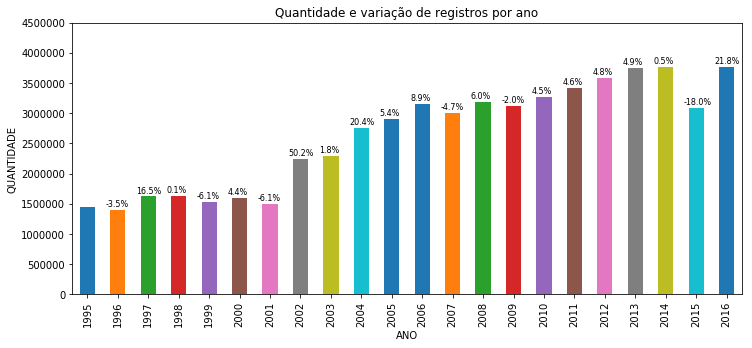

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Calcula a variação (%) para cada ano
variacao = [] # 1996-2016

for i in range(1,len(registros_ano-1)):
    variacao.append(((registros_ano.iloc[i]/registros_ano.iloc[i-1])-1)*100)

plt.figure(figsize=(12,5))
ax = registros_ano.plot.bar()
ax.set_title("Quantidade e variação de registros por ano")
ax.set_ylabel("QUANTIDADE")
ax.set_xlabel("ANO")
ax.set_ylim(0,4500000)

i=1
for v in variacao:
    y = registros_ano.iloc[i]+60000
    x = i-0.4
    ax.text(x,y,str(round(v,1))+'%',size=8)        
    i += 1

#### Pensões

Abaixo é apresentada a quantidade de pensões concedidas em cada ano.

In [10]:
# Extrai os valores de DDB do banco
registros_ano = run_query("SELECT DDB FROM pensoes")
# Remove as informações de dia e mês e salva somente os dados de ano (12/12/1995 --> 1995)
registros_ano['DDB'] = registros_ano['DDB'].apply(lambda x: int(x[-4:]))
# Calcula a frequência para cada ano
registros_ano = registros_ano['DDB'].value_counts().sort_index()
registros_ano

1995    333385
1996    290213
1997    294890
1998    297699
1999    293060
2000    307673
2001    286587
2002    346783
2003    320152
2004    347553
2005    338794
2006    355473
2007    381752
2008    390339
2009    403655
2010    410144
2011    421393
2012    424918
2013    441913
2014    436369
2015    387383
2016    454057
Name: DDB, dtype: int64

No caso das pensões, também observa-se variação na quantidade de pensões concedidas em cada ano, com uma tendência de crescimento, conforme gráfico abaixo:

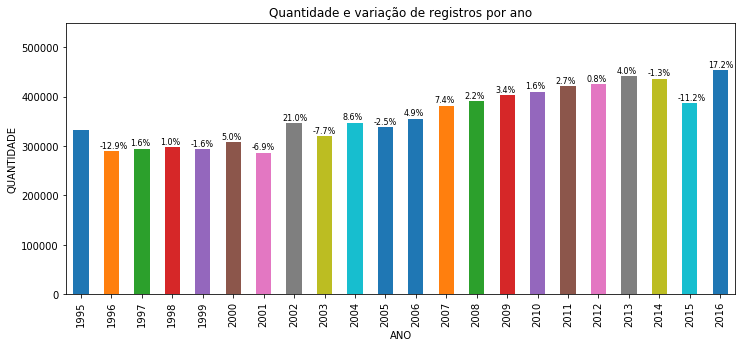

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# Calcula a variação (%) para cada ano
variacao = [] # 1996-2016

for i in range(1,len(registros_ano-1)):
    variacao.append(((registros_ano.iloc[i]/registros_ano.iloc[i-1])-1)*100)

plt.figure(figsize=(12,5))
ax = registros_ano.plot.bar()
ax.set_title("Quantidade e variação de registros por ano")
ax.set_ylabel("QUANTIDADE")
ax.set_xlabel("ANO")
ax.set_ylim(0,550000)

i=1
for v in variacao:
    y = registros_ano.iloc[i]+6000
    x = i-0.4
    ax.text(x,y,str(round(v,1))+'%',size=8)        
    i += 1

# Registros por situação

Um outro campo de suma importância nos registros é a sua situação (Ativo, Cessado, Suspenso etc).

Assim, abaixo segue um análise dos registros por situação.

#### Aposentadorias e Auxílios

In [12]:
# Realiza a Query no banco de dados
reg_situacao = run_query("SELECT SITUACAO, COUNT(SITUACAO) AS QUANTIDADE FROM apos_aux GROUP BY SITUACAO ORDER BY QUANTIDADE DESC")
# Substitui os códigos da coluna SITUACAO pelo texto correspondente
reg_situacao['SITUACAO'] = reg_situacao['SITUACAO'].apply(lambda x: codigos_situacao[x])
# Adiciona mais uma coluna com a porcentagem relativa em relação ao total
reg_situacao['PROPORCAO (%)'] = 100*(reg_situacao['QUANTIDADE']/reg_situacao['QUANTIDADE'].sum())
reg_situacao

,SITUACAO,QUANTIDADE,PROPORCAO (%)
0,CESSADO,37375130,64.488944
1,ATIVO,17480837,30.162322
2,CESSADO PELO SISOBI,2984389,5.149416
3,SUSPENSO,50504,0.087142
4,CESSADO PELA INSPETORIA,17961,0.030991
5,SUSPENSO PELO CONPAG,14190,0.024484
6,CESSADO PELA AUDITORIA,11388,0.019649
7,SUSPENSO PELA AUDITORIA,10257,0.017698
8,SUSPENSO PELO SISOBI,7918,0.013662
9,CANCELADO PELA AUDITORIA,1785,0.003080


É observado que a maioria dos registros está em situação de CESSADO (mais de 65%), havendo somente 17.4 milhões de benefícios ativos, que corresponde a 30% dos registros.

#### Pensões

In [13]:
# Realiza a Query no banco de dados
reg_situacao = run_query("SELECT SITUACAO, COUNT(SITUACAO) AS QUANTIDADE FROM pensoes GROUP BY SITUACAO ORDER BY QUANTIDADE DESC")
# Substitui os códigos da coluna SITUACAO pelo texto correspondente
reg_situacao['SITUACAO'] = reg_situacao['SITUACAO'].apply(lambda x: codigos_situacao[x])
# Adiciona mais uma coluna com a porcentagem relativa em relação ao total
reg_situacao['PROPORCAO (%)'] = 100*(reg_situacao['QUANTIDADE']/reg_situacao['QUANTIDADE'].sum())
reg_situacao

,SITUACAO,QUANTIDADE,PROPORCAO (%)
0,ATIVO,5811140,72.965909
1,CESSADO,1981535,24.880575
2,CESSADO PELO SISOBI,133430,1.675375
3,SUSPENSO,25735,0.323134
4,SUSPENSO PELO CONPAG,5313,0.066711
5,SUSPENSO PELO SISOBI,4428,0.055599
6,CESSADO PELA AUDITORIA,1433,0.017993
7,SUSPENSO PELA AUDITORIA,698,0.008764
8,CANCELADO PELA AUDITORIA,205,0.002574
9,CESSADO PELA INSPETORIA,141,0.001770


No caso das pensões, a maioria dos registros são de benefícios ativos (73%).

# Conclusões

Está breve análise buscou apresentar uma visão geral dos dados presentes nas tabelas **apos_aux** e **pensoes**.

As principais observações foram:
* A tabela **apos_aux** possui mais de 57 milhões de registros e a tabela **pensoes** possui quase 8 milhões de registros.
* O benefício com maior número de registros é o Auxílio-doença previdenciário
* Apenas 10 tipos de benefícios, de um total de 78, estão presentes nos dados.
* A maioria dos benefícios de aposentadorias e auxílios foram concendidos nos últimos 14 anos 
* Apenas 30% do total de benefícios de aposentadorias e auxílios (para todos os anos) estão ATIVOS.
* 72% do total de pensões estão ATIVAS.

Os outros documentos deste projeto apresentam análises mais detalhadas para cada um dos tipos de benefícios contidos nas tabelas.